###  Modèle CNN type LeNet avec détourage et recadrage 256x256


In [4]:
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt
import cv2
import seaborn as sns

import pandas as pd
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, Input, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential

from keras.applications.mobilenet import preprocess_input

from tensorflow.keras.callbacks import EarlyStopping
from keras.applications import MobileNet
from sklearn import metrics
import tensorflow as tf


#### Récupération de la base d'images et création jeu d'évaluation, de test et d'entrainement

In [5]:
data = pd.read_csv('../files_detour_256.csv',index_col=0)

In [6]:
src_img = '../images_detour_256/'

In [7]:
data['file_path'] = data['filename'].apply(lambda file :  src_img + file)

In [8]:
lst_classes = {'basophil':0,'blast':1,'eosinophil':2,
               'erythroblast':3,'ig':4,'lymphocyte':5,'monocyte':6,'neutrophil':7,'platelet':8,'smudge':9}

In [9]:
data['label'] = data['class'].apply(lambda cat: lst_classes[cat])

In [10]:
data.head()

,index,file_path,filename,class,label
0,0,../images_detour_256/BA_100102.jpg,BA_100102.jpg,basophil,0
1,1,../images_detour_256/BA_101381.jpg,BA_101381.jpg,basophil,0
2,2,../images_detour_256/BA_101611.jpg,BA_101611.jpg,basophil,0
3,3,../images_detour_256/BA_102039.jpg,BA_102039.jpg,basophil,0
4,4,../images_detour_256/BA_102750.jpg,BA_102750.jpg,basophil,0


In [11]:
data_train, data_eval = train_test_split(data,test_size=0.1,random_state=123)
data_train, data_test = train_test_split(data_train,test_size=0.1,random_state=123)

##### Mise au format Tensor

In [12]:
def load_and_preprocess(img_filepath):
    img = tf.io.read_file(img_filepath)
    img = tf.io.decode_jpeg(img, channels=3)
#     img = tf.image.resize(img, [256,256]) / déjà redimensionné par detourage
    img = tf.cast(img, tf.float32)/255.
    return img

In [13]:
AUTO = tf.data.experimental.AUTOTUNE

In [14]:
dataset_train = tf.data.Dataset.from_tensor_slices((data_train['file_path'],data_train['label']))
dataset_test = tf.data.Dataset.from_tensor_slices((data_test['file_path'],data_test['label']))

dataset_train = (dataset_train.map(lambda x, y : [load_and_preprocess(x), y], num_parallel_calls=AUTO).prefetch(AUTO).shuffle(1000).batch(32))
dataset_test = (dataset_test.map(lambda x, y : [load_and_preprocess(x), y], num_parallel_calls=AUTO).prefetch(AUTO).shuffle(500).batch(32))

#### Modèle type LeNet
* Couches Dense 1024, 512, 256 
* Dropout pour éviter overfitting
* Compilation avec Adam avec learning_rate de 10-4

In [15]:
# Création Callback pour stopper si stagnation
callback = EarlyStopping(monitor='val_loss', patience=3,restore_best_weights=True)

In [16]:
# Création d'un modèle type LeNet
def model_CNN():
    model =  Sequential()
    model.add(Conv2D(filters = 30  , kernel_size=(5,5), padding='valid', input_shape=(256,256,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters = 16  , kernel_size=(3,3), padding='valid', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(rate=0.2))
    model.add(Flatten())
    model.add(Dense(units=1024,activation='relu'))
    model.add(Dense(units=512,activation='relu'))
    model.add(Dense(units=256,activation='relu'))
    model.add(Dense(units=10,activation='softmax')) #10 Classes
    #Compilation
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [17]:
model = model_CNN()

In [18]:
#Entrainement
history = model.fit(dataset_train, epochs = 16, validation_data = dataset_test,callbacks=[callback])

Epoch 1/16
800/800 [==============================] - 1545s 2s/step - loss: 0.9560 - accuracy: 0.6678 - val_loss: 0.6842 - val_accuracy: 0.7656
Epoch 2/16
800/800 [==============================] - 1605s 2s/step - loss: 0.5283 - accuracy: 0.8178 - val_loss: 0.5590 - val_accuracy: 0.8074
Epoch 3/16
800/800 [==============================] - 1628s 2s/step - loss: 0.4018 - accuracy: 0.8632 - val_loss: 0.5226 - val_accuracy: 0.8327
Epoch 4/16
800/800 [==============================] - 1655s 2s/step - loss: 0.3080 - accuracy: 0.8980 - val_loss: 0.4652 - val_accuracy: 0.8443
Epoch 5/16
800/800 [==============================] - 1726s 2s/step - loss: 0.2277 - accuracy: 0.9252 - val_loss: 0.5210 - val_accuracy: 0.8422
Epoch 6/16
800/800 [==============================] - 1638s 2s/step - loss: 0.1544 - accuracy: 0.9502 - val_loss: 0.4826 - val_accuracy: 0.8622
Epoch 7/16
800/800 [==============================] - 1638s 2s/step - loss: 0.1064 - accuracy: 0.9656 - val_loss: 0.5244 - val_accuracy:

In [19]:
model.save_weights("cnn_10_detour_weights")

#### Prédiction sur les données d'évaluation

In [15]:
# model = model_mobileNet()
# model.load_weights("cnn_10_detour_weights")

In [21]:
dataset_eval = tf.data.Dataset.from_tensor_slices((data_eval['file_path'],data_eval['label']))
dataset_eval = (dataset_eval.map(lambda x, y : [load_and_preprocess(x), y], num_parallel_calls=AUTO).prefetch(AUTO).batch(32))

In [23]:
model.evaluate(dataset_eval)

99/99 [==============================] - 55s 558ms/step - loss: 0.4893 - accuracy: 0.8349


[0.48925819993019104, 0.8348624110221863]

 * Score inférieur avec détourage de 2%

In [24]:
#Classes prédites
predict = model.predict(dataset_eval)

In [25]:
lst_classes = ['basophil','blast','eosinophil',
               'erythroblast','ig','lymphocyte','monocyte','neutrophil','platelet','smudge']
eval_predict_class = predict.argmax(axis = 1)
eval_predict_class_name = [lst_classes[i] for i in eval_predict_class]
eval_class_name = [lst_classes[i] for i in data_eval['label'] ]
print(metrics.classification_report( eval_class_name,eval_predict_class_name ))

              precision    recall  f1-score   support

    basophil       0.71      0.89      0.79       118
       blast       0.82      0.73      0.77       325
  eosinophil       0.96      0.96      0.96       320
erythroblast       0.95      0.81      0.87       217
          ig       0.68      0.59      0.63       386
  lymphocyte       0.91      0.88      0.90       467
    monocyte       0.74      0.72      0.73       264
  neutrophil       0.89      0.96      0.93       580
    platelet       0.96      1.00      0.98       231
      smudge       0.63      0.78      0.70       253

    accuracy                           0.83      3161
   macro avg       0.83      0.83      0.83      3161
weighted avg       0.84      0.83      0.83      3161



> Score plus faible sur toutes les classes

In [26]:
pd.crosstab(pd.Series(eval_class_name, name='Réalité'),pd.Series(eval_predict_class_name, name='Prédiction'))

Prédiction,basophil,blast,eosinophil,erythroblast,ig,lymphocyte,monocyte,neutrophil,platelet,smudge
Réalité,,,,,,,,,,
basophil,105,1,3,1,5,1,0,1,0,1
blast,1,236,0,0,18,7,32,0,1,30
eosinophil,2,0,307,0,4,0,0,3,0,4
erythroblast,2,1,0,175,12,12,2,10,3,0
ig,32,29,2,1,227,7,22,32,0,34
lymphocyte,2,1,1,5,11,413,2,5,2,25
monocyte,2,11,0,0,39,4,189,4,0,15
neutrophil,1,0,6,1,7,1,1,558,0,5
platelet,0,0,0,0,0,0,0,0,231,0


In [27]:
# Récupère les cellules bien prédites => regarde la proba sur cette classe
compare = pd.DataFrame({'Réalité':data_eval['label'],'Prédiction':eval_predict_class}).reset_index()
predict_correct = compare[compare['Réalité']==compare['Prédiction']]

In [28]:
predict_by_class = []
for i in range(10):
    indexes = predict_correct[predict_correct['Réalité']==i].index
    pourcent = predict[indexes][:,i]
    predict_by_class.append(pourcent)

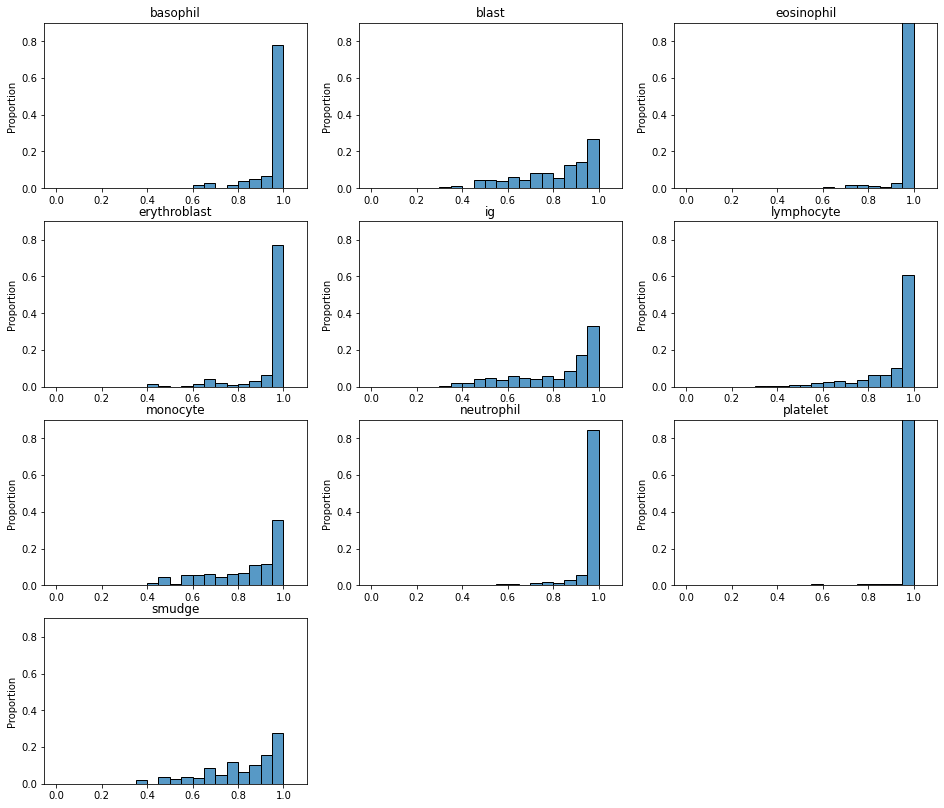

In [29]:
fig = plt.figure(figsize=(16,14))
for i in range(10):
        ax = fig.add_subplot(4, 3, i + 1)
        ax.set_ylim([0,0.9])
        plt.title(lst_classes[i])
        sns.histplot(x=predict_by_class[i],ax=ax,stat='proportion', bins = np.arange(0,1.1,0.05) )


### GRAD CAM

In [30]:
import gradcam_dataset

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 252, 252, 30)      2280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 30)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 16)      4336      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 62, 62, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 61504)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              6

In [32]:
img_size = (255, 255)
last_conv_layer_name = "conv2d_1"

##### BASOPHIL

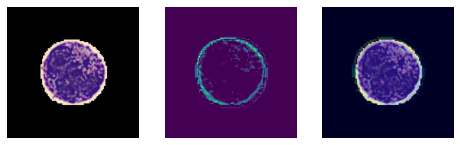

In [33]:
path = data[data['filename']=='BA_799126.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=0)

##### BLAST

Cellule non prédite dans la catégorie attendue


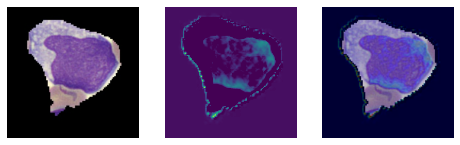

In [34]:
path = data[data['filename']=='BL_6995975.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=1)

##### EOSINOPHIL

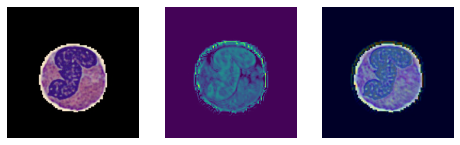

In [35]:
path = data[data['filename']=='EO_336686.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=2)

##### ERYTHROBLAST

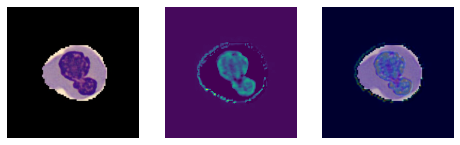

In [36]:
path = data[data['filename']=='ERB_763618.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=3)

##### IG

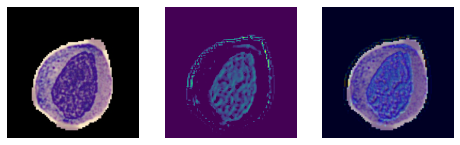

In [37]:
path = data[data['filename']=='MY_582963.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=4)

##### LYMPHOCYTE

Cellule non prédite dans la catégorie attendue


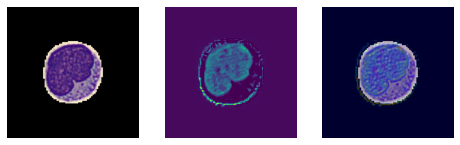

In [38]:
path = data[data['filename']=='LY_875873.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=5)

##### MONOCYTE

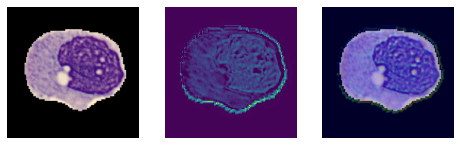

In [39]:
path = data[data['filename']=='MO_144054.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=6)

##### NEUTROPHIL

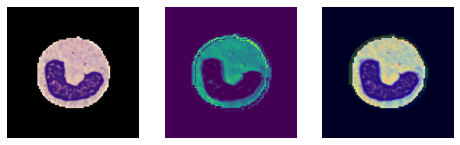

In [40]:
path = data[data['filename']=='BNE_495973.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=7)

##### PLATELET

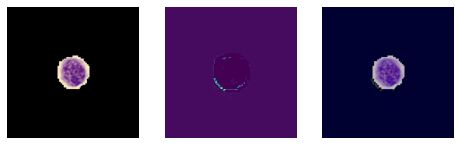

In [41]:
path = data[data['filename']=='PLATELET_19307.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=8)

##### SMUDGE

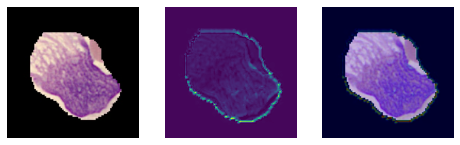

In [42]:
path = data[data['filename']=='SMU_13827002.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=9)